In [1]:
import os
import pandas as pd
import pickle 
import numpy as np
# from shogun import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random

import time
import ksd
import mmd
import tf_ops

/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ak/anaconda3/envs/mmd-kernels/lib/pyt

In [2]:

%matplotlib inline
import matplotlib as mpl

import seaborn as sns
sns.set(context='notebook')
from IPython.display import display, Markdown, HTML

from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm  # if you're in JupyterLab/etc and this doesn't work well

import functools

import numpy as np
import sklearn
from sklearn import model_selection
import torch

import ds3_support as ds3s
from ds3_support import as_tensors, LazyKernel, pil_grid

In [3]:
torch.set_default_tensor_type(torch.DoubleTensor)
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
# getting all the data in 
ActivityCLockData= '/media/ak/My Passport/Experiment Data/ActivityClockData/'
OHLCData= '/media/ak/My Passport/Experiment Data/OHLCData/'
folderList = os.listdir(ActivityCLockData)
OHLCDataList = os.listdir(OHLCData)
ActivityClockDataList = os.listdir(ActivityCLockData)

symbols =['FB1','JB1','FV1','G_1']

In [5]:
symbol1= symbols[1]
Symbol1ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and (str(symbol1)) in s])
Symbol1tickBarDictCondensed = dict()


In [6]:
for pklidx,_ in enumerate(Symbol1ClocksData):
    print(pklidx)
    pklClockFile = "".join((ActivityCLockData,Symbol1ClocksData[pklidx]))
    print(pklClockFile)
    tickBarDF =pickle.load(open(pklClockFile , "rb"))['TickBarDf'] #tickbar
    Symbol1tickBarDictCondensed[Symbol1ClocksData[pklidx].split('_')[3]]=tickBarDF [['BidSize', 'QuoteTime','BestBid',
       'TradeTime', 'AskSize','BestAsk', 'TradeVolume', 'TradedTime', 'type',
       'TradePrice', 'TimeStamp', 'milliSeconds','DollarVolume', 'MicroPrice', 'TradeSize', 'DollarVolumeTraded']]
   

0
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180413_.pkl
1
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180416_.pkl
2
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180417_.pkl
3
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180418_.pkl
4
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180419_.pkl
5
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180420_.pkl
6
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180423_.pkl
7
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180424_.pkl
8
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180425_.pkl
9
/media/ak/My Passport/Experiment Data/ActivityClockData/ClocksData_JB1_Comdty_20180426_.pkl
10
/media/ak/My Passport/Experiment Data/ActivityClockData/C

In [7]:
symbol2= symbols[3]
Symbol2ClocksData = np.sort([s for s in os.listdir(ActivityCLockData) if 'Clocks' in s and (str(symbol2)) in s])
Symbol2tickBarDictCondensed = dict()
for pklidx in range(0,19):
    pklClockFile = "".join((ActivityCLockData,Symbol2ClocksData[pklidx]))
    tickBarDF =pickle.load(open(pklClockFile , "rb"))['TickBarDf'] #tickbar
    Symbol2tickBarDictCondensed[Symbol2ClocksData[pklidx].split('_')[4]]=tickBarDF [['BidSize', 'QuoteTime','BestBid',
       'TradeTime', 'AskSize','BestAsk', 'TradeVolume', 'TradedTime', 'type',
       'TradePrice', 'TimeStamp', 'milliSeconds','DollarVolume', 'MicroPrice', 'TradeSize', 'DollarVolumeTraded']]


In [8]:
Symbol1keys = list(Symbol1tickBarDictCondensed.keys())
Symbol2keys = list(Symbol2tickBarDictCondensed.keys())

In [9]:
mp1 = pd.concat(list(Symbol1tickBarDictCondensed.values() ), axis=0, keys=Symbol1keys)
mp2 = pd.concat(list(Symbol2tickBarDictCondensed.values() ), axis=0, keys=Symbol2keys)


In [10]:
print(mp1.shape, mp2.shape)

(108090, 16) (223038, 16)


In [11]:
mp1['MicroPriceChange']=mp1.MicroPrice.pct_change()
mp2['MicroPriceChange']=mp2.MicroPrice.pct_change()

In [12]:
X =mp1[(mp1.MicroPriceChange<mp1.MicroPriceChange.quantile(.95)) & (mp1.MicroPriceChange>mp1.MicroPriceChange.quantile(.05))].MicroPriceChange.values

In [13]:
Y =mp2[(mp2.MicroPriceChange<mp2.MicroPriceChange.quantile(.95)) & (mp2.MicroPriceChange>mp1.MicroPriceChange.quantile(.05))].MicroPriceChange.values

In [16]:
from scipy import signal
Y_ds =  signal.resample(Y, 20000)
X_ds = signal.resample(X, 20000)

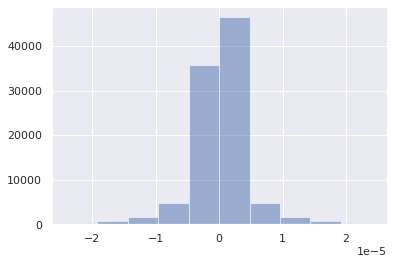

In [48]:
_=plt.hist(X, alpha=0.5)
#_=plt.hist(Y, alpha=0.5, color='red')

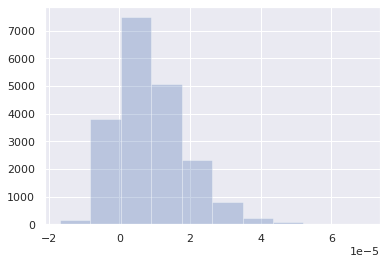

In [49]:

_=plt.hist(Y_ds, alpha = 0.3)

In [19]:
 X_torch, Y_torch = as_tensors(X_ds, Y_ds) #reproduce tensors

In [20]:
from scipy.spatial.distance import squareform, pdist, cdist

def sq_distances(X,Y=None):
    """
    If Y=None, then this computes the distance between X and itself
    """
    assert(X.ndim==2)

    # IMPLEMENT: compute pairwise distance matrix. Don't use explicit loops, but the above scipy functions
    # if X=Y, use more efficient pdist call which exploits symmetry
    if Y is None:
        sq_dists = squareform(pdist(X, 'sqeuclidean'))
    else:
        assert(Y.ndim==2)
        assert(X.shape[1]==Y.shape[1])
        sq_dists = cdist(X, Y, 'sqeuclidean')

    return sq_dists

In [21]:
def mean_difference(X, Y, squared=False):
    X, Y = as_tensors(X, Y)
    assert len(X.shape) == len(Y.shape) == 1
    
    # TODO: compute mean difference of X and Y
    result = X.mean() - Y.mean()  # SOLUTION
    
    return (result * result) if squared else result



In [22]:
def two_sample_permutation_test(
    test_statistic, X, Y, num_permutations=1000, progress=True
):
    X, Y = as_tensors(X, Y)
    assert len(X.shape) == len(Y.shape)
    
    orig_stat = test_statistic(X, Y)
    
    range_ = range(num_permutations)
    if progress:
        range_ = tqdm(range_)
    
    # concatenate samples together
    Z = torch.cat([X, Y], 0)
    
    stats = []
    n_X = X.shape[0]                                  # SOLUTION
    for i in range_:
        # TODO: permute samples and compute test statistic
        np.random.shuffle(Z.numpy())                  # SOLUTION
        this_stat = test_statistic(Z[:n_X], Z[n_X:])  # SOLUTION
        stats.append(this_stat)
    return orig_stat, torch.stack(stats)

In [23]:
def plot_permutation_samples(statistic, null_samples, ax=None,
                             from_zero=False, one_sided=False, alpha=1,
                             level=.05):    
    null_samples = np.asarray(null_samples)
    if ax is None:
        ax = plt.gca()
    
    ax.hist(null_samples, bins='auto', histtype='stepfilled',
            label="Permutation samples", alpha=alpha)
    
    if from_zero:
        lo = 0
        hi = np.percentile(null_samples, 100 * (1 - level))
    elif one_sided:
        lo = np.min(null_samples)
        # should be -inf, but that takes more code
        hi = np.percentile(null_samples, 100 * (1 - level))
    else:
        lo = np.percentile(null_samples, 100 * level / 2)
        hi = np.percentile(null_samples, 100 * (1 - level / 2))
    
    ax.axvspan(lo, hi, fc='b', alpha=.25, label="95% region")
    
    ax.axvline(x=statistic, c='r', lw=2, label="Actual statistic")
    ax.legend(loc='best')
    
    ax.set_xlabel("Test statistic value")
    ax.set_ylabel("Counts")
    
    if from_zero:
        ax.set_xlim(0, ax.get_xlim()[1])

In [24]:
def gaussian_kernel_median_heuristic(Z):
    # IMPLEMENT: compute the median of the pairwise distances in Z
    # (not taking zero distance between identical samples (diagonal) into account)
    sq_dists = sq_distances(Z)
    np.fill_diagonal(sq_dists, np.nan)
    sq_dists = np.ravel(sq_dists)
    sq_dists = sq_dists[~np.isnan(sq_dists)]
    median_dist = np.median(np.sqrt(sq_dists))
    
    return np.sqrt(median_dist/2.0) # our kernel uses a bandwidth of 2*(sigma**2)

sigma_median = gaussian_kernel_median_heuristic(np.vstack((X_torch[:,np.newaxis],Y_torch[:,np.newaxis])))
print(sigma_median)

0.001598079435686809


/home/ak/anaconda3/envs/mmd-kernels/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


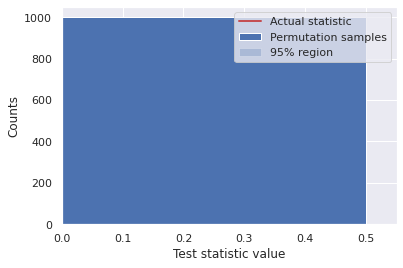

In [25]:

def mean_std_stat(X, Y):
    X, Y = as_tensors(np.asanyarray(X), np.asanyarray(X))
    assert len(X.shape) == len(Y.shape) == 1
    # TODO: implement
    
    return (X.mean() - Y.mean()) ** 2 + (X.std() - Y.std()) ** 2

plot_permutation_samples(
    *two_sample_permutation_test(mean_std_stat, X_torch, Y_torch),
    from_zero=True)

In [26]:
class LinearKernel(LazyKernel):
    def _compute(self, A, B):
        return A @ B.t()

In [27]:
class RBFKernel(LazyKernel):
    def __init__(self, *parts, sigma=1):
        super().__init__(*parts)
        self.sigma = sigma
        self.const_diagonal = 1  # Says that k(x, x) = 1 for any x
    
    # TODO: implement _compute (maybe with _precompute)
    def _precompute(self, A):                                            # SOLUTION
        # Squared norms of each data point                               # SOLUTION
        return [torch.einsum("ij,ij->i", A, A)]                          # SOLUTION
                                                                         # SOLUTION
    def _compute(self, A, A_sqnorms, B, B_sqnorms):                      # SOLUTION
        D2 = A_sqnorms[:, None] + B_sqnorms[None, :] - 2 * (A @ B.t())   # SOLUTION
        return torch.exp(D2 / (-2 * self.sigma ** 2))  

## matrix classes ##

In [28]:
# make X, Y into [n, 1] matrices instead of just vectors
if len(X_torch.shape) == 1:
    X_torch = X_torch[:, None]
if len(Y_torch.shape) == 1:
    Y_torch = Y_torch[:, None]

In [29]:
K = RBFKernel(X_torch, Y_torch)

In [32]:
K.XY_m.mat

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [33]:
K.XX_m.mean(), K.XX_m.offdiag_mean()

(tensor(1.0000), tensor(1.0000))

In [38]:
def mmd2_biased(K):
    pass  # TODO: implement, using K.XX, K.XY, K.YY (or _m)
    return K.XX_m.mean() + K.YY_m.mean() - 2 * K.XY_m.mean()  # SOLUTION

def mmd2_unbiased(K):
    pass  # TODO: implement
    return K.XX_m.offdiag_mean() + K.YY_m.offdiag_mean() - 2 * K.XY_m.mean()  # SOLUTION

def mmd2_u_stat(K):
    assert K.ns[0] == K.ns[1]
    # TODO: implement
    return K.XX_m.offdiag_mean() + K.YY_m.offdiag_mean() - 2 * K.XY_m.offdiag_mean()  # SOLUTION

In [39]:
plot_permutation_samples(
    *two_sample_permutation_test(lambda X_torch, Y_torch: mmd2_unbiased(RBFKernel(X, Y)), X, Y),
    one_sided=True)

AssertionError: 

In [40]:
# SOLUTION CELL
def mmd2_permutations(K, use_biased=True, permutations=1000, progress=None):
    # progress is ignored
    full_kernel = K.joint()
    assert K.n_parts == 2
    n_X, n_Y = K.ns
    n = n_X + n_Y

    if use_biased:
        w_X = 1 / n_X
        w_Y = -1 / n_Y
    else:  # use U statistic
        assert n_X == n_Y
        w_X = 1
        w_Y = -1

    ws = torch.full((permutations + 1, n), w_Y,
                    dtype=full_kernel.dtype, device=full_kernel.device)
    ws[-1, :n_X] = w_X
    for i in range(permutations):
        ws[i, np.random.choice(n, n_X, replace=False)] = w_X

    biased_ests = torch.einsum("pi,ij,pj->p", ws, full_kernel, ws)
    if use_biased:
        ests = biased_ests
    else:
        # need to subtract \sum_i k(X_i, X_i) + k(Y_i, Y_i) + 2 k(X_i, Y_i)
        # first two are just trace, but last is harder:
        is_X = ws > 0
        X_inds = is_X.nonzero()[:, 1].view(permutations + 1, n_X)
        Y_inds = (~is_X).nonzero()[:, 1].view(permutations + 1, n_Y)
        del is_X, ws
        cross_terms = K.take(Y_inds * n + X_inds).sum(1)
        del X_inds, Y_inds
        ests = (biased_ests - K.trace() + 2 * cross_terms) / (n_X * (n_X - 1))

    est = ests[-1]
    rest = ests[:-1]
    return est, rest

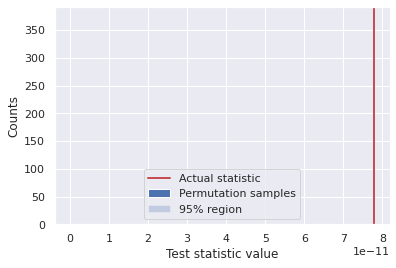

In [41]:
plot_permutation_samples(*mmd2_permutations(K))

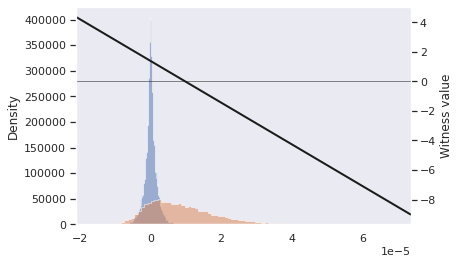

In [42]:
def mmd_witness(K, eval_pts):
    assert K.n_parts == 2
    K.append_part(eval_pts[:, None])  # now K.XZ compares X to eval_pts
    
    witness = 0
    # TODO: estimate MMD witness function on grid_pts
    witness = K.XZ.mean(0) - K.YZ.mean(0)  # SOLUTION
    
    K.drop_last_part()
    witness = witness / mmd2_biased(K)  # to normalize; not necessary  # SOLUTION
    return witness

def plot_mmd_witness_1d(K, ax=None, grid_num=1000):
    X, Y = [t.squeeze(1) for t in K.parts]
    assert len(X.shape) == 1
    
    if ax is None:
        ax = plt.gca()
    ax.hist(X.numpy(), alpha=.5, density=True, histtype='stepfilled', bins='auto')
    ax.hist(Y.numpy(), alpha=.5, density=True, histtype='stepfilled', bins='auto')
    ax.grid(False)
    ax.set_ylabel("Density")
    
    ax2 = ax.twinx()
    lo, hi = ax2.get_xlim()
    grid_pts = torch.linspace(lo, hi, grid_num)
    ax2.plot(grid_pts.numpy(), mmd_witness(K, grid_pts).numpy(), color='k', lw=2)
    ax2.set_xlim(lo, hi)
    ax2.grid(False)
    ax2.axhline(0, color='k', lw=0.5)
    ax2.set_ylabel("Witness value")

x_torch = torch.from_numpy(X).double()
y_torch = torch.from_numpy(Y).double()
    
plot_mmd_witness_1d(RBFKernel(X_torch, Y_torch))

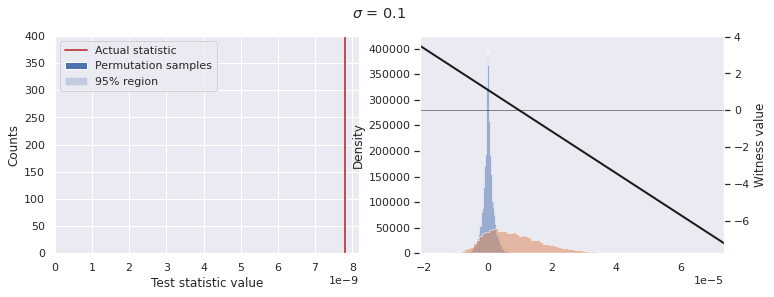

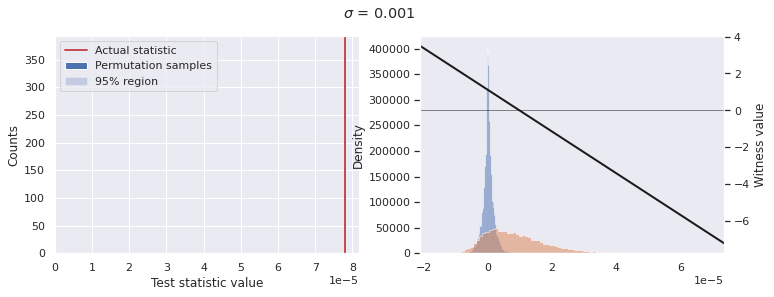

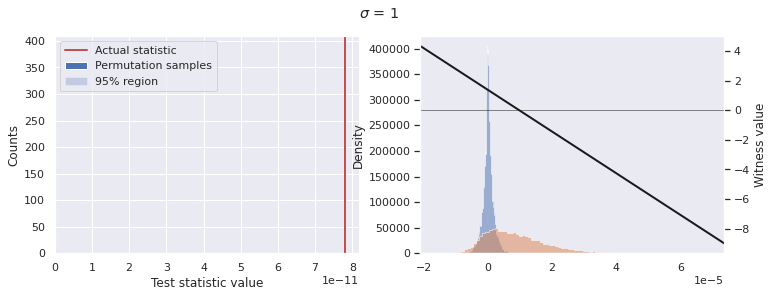

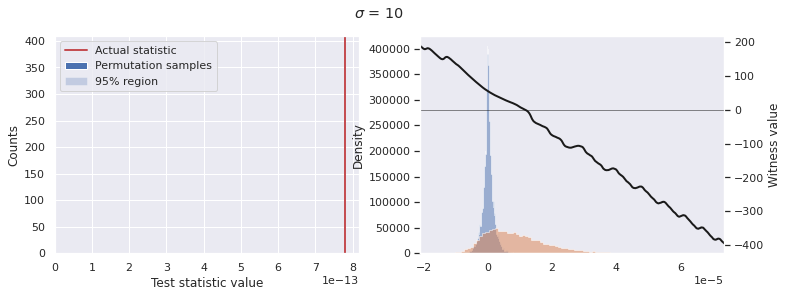

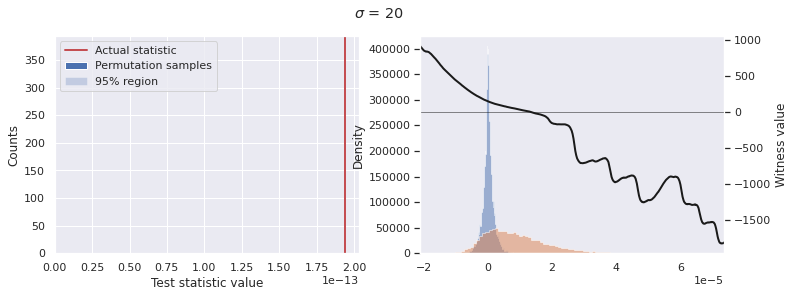

In [46]:
for sig in [.1, .001, 1,10,20]:
    K = RBFKernel(X_torch, Y_torch, sigma=sig)
    fig, (a1, a2) = plt.subplots(ncols=2, figsize=(12, 4))
    plot_permutation_samples(*mmd2_permutations(K), ax=a1, from_zero=True)
    plot_mmd_witness_1d(K, ax=a2)
    fig.suptitle(f"$\sigma$ = {sig}")

5.107715762223786e-06

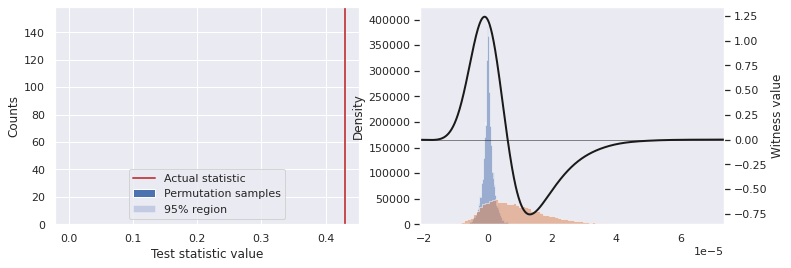

In [47]:
def median_distance(Z):
    # TODO: compute the median distance among the stacked samples Z
    # If you want to be fancy, add options to optionally subset if Z is big.
    median_dist = torch.median(torch.pdist(Z))  # SOLUTION
    return median_dist

med = median_distance(torch.cat([X_torch, Y_torch], 0))
K = RBFKernel(X_torch, Y_torch, sigma=med)

fig, (a1, a2) = plt.subplots(ncols=2, figsize=(12, 4))
plot_permutation_samples(*mmd2_permutations(K), ax=a1, one_sided=True)
plot_mmd_witness_1d(K, ax=a2)

med.item()

In [ ]:
from ds3_support import mmd2_u_stat_variance

In [ ]:
mmd2_u_stat_variance?